# 0. required packages for h5py

In [1]:
%run "C:\Users\shiwei\Data Analysis\ImageAnalysis3\required_files\Startup_py3.py" 

sys.path.append(r"C:\Users\shiwei\Data Analysis")
import ImageAnalysis3 as ia 
%matplotlib notebook
from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

4228


# 1. Create field-of-view class

In [2]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

before_fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\Before_clearing',
             'save_folder':r'V:\20201221-Acr_ctp08_P_brain\Before_clearing\New',
             #'save_folder':r'D:\Pu_Temp\202009_IgH_proB_DMSO_2color',
             'experiment_type': 'DNA',
             'num_threads': 12,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201204-Corrections_3color_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':150,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(5,11)

In [3]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes

overwrite_spot=False
overwrite_chrom=False
intensity_th = 200

before_fov_ids_list = []
before_chrom_ims = []
before_chrom_coords_list = []
before_cand_chr_spots_list = []



for _fov_id in fov_ids:

    # create fov class
    before_fov = classes.field_of_view.Field_of_View(before_fov_param, _fov_id=_fov_id,
        _color_info_kwargs={
          '_color_filename':'Color_Usage',
        }, 
        _prioritize_saved_attrs=False,
        )

    # process image into spots
    before_id_list, before_spot_list = before_fov._process_image_to_spots('unique', 
         #_sel_ids=np.arange(41,72),
         _load_common_reference=True,
         _load_with_multiple=False,
         _save_images=True,
         _warp_images=False, 
         _overwrite_drift=False,
         _overwrite_image=False,
         _overwrite_spot=overwrite_spot,
         _verbose=True)
    # identify chromosomes
    before_fov._load_from_file('unique')
    
    if not hasattr(before_fov, 'chrom_im'):
        _chrom_im = before_fov._load_chromosome_image(_overwrite=overwrite_chrom)
    if not hasattr(before_fov, 'chrom_coords'):
        _chrom_coords = before_fov._find_candidate_chromosomes_by_segmentation(
            _filt_size=4,
            _binary_per_th=99.75,
            _morphology_size=2,
            _overwrite=overwrite_chrom)
        _chrom_coords = before_fov._select_chromosome_by_candidate_spots(
            _good_chr_loss_th=0.3, _cand_spot_intensity_th=200,
            _overwrite=overwrite_chrom,
            _save=True)

    # append
    before_chrom_ims.append(before_fov.chrom_im)
    before_chrom_coords_list.append(before_fov.chrom_coords)
    before_fov_ids_list.append(_fov_id*np.ones(len(before_fov.chrom_coords)))
    
    before_fov_cand_chr_spots_list = [[] for _ct in before_fov.chrom_coords]

    # finalize candidate spots
    for _spots in before_fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, before_fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            before_fov_cand_chr_spots_list[_i].append(_cands)
            
    before_cand_chr_spots_list += before_fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(before_fov.chrom_coords)}")

# combine acquired spots and chromosomes
before_chrom_coords = np.concatenate(before_chrom_coords_list)
before_fov_ids_list = np.concatenate(before_fov_ids_list).astype(np.int)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
before_dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, before_fov.shared_parameters['distance_zxy'])
                       for _spots in before_cand_chr_spots_list]
before_dna_reg_ids = before_fov.unique_ids

print(f"{len(before_chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 88
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\Before_clearing\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 11 folders are found according to color-usage annotation.
+ creating save folder: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumin

C:\Users\shiwei\Data Analysis\ImageAnalysis3\classes\field_of_view.py:1448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


++ finish loading unique in 0.202s. 
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\Before_clearing\H0R0\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201221-Acr_ctp08_P_brain\Before_clearing\H0R0\Conv_zscan_05.dax  in 4.398s
-- removing hot pixels for channels:['750'] in 13.299s
-- illumination correction for channels: 750, in 2.560s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 141.731s
-- finish correction in 175.076s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_05.hdf5
++ base attributes saved:['chrom_im'] in 11.438s.
+ load

C:\Users\shiwei\Anaconda3\lib\site-packages\skimage\segmentation\random_walker_segmentation.py:470: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  inds_isolated_seeds, isolated_values) = _preprocess(labels)


-- find objects larger than size=50
-- 233 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 12 threads in 232.264s.
-- saving fov_info to file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_05.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.110s.
+ loading fov_info from file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_05.hdf5
++ base attributes loaded:[] in 1.634s.
- start select from 233 chromosomes with loss threshold=0.3
-- remove chr id 30, percentage of lost rounds:0.952.
-- remove chr id 139, percentage of lost rounds:0.952.
-- remove chr id 53, percentage of lost rounds:0.762.
-- remove chr id 185, percentage of lost rounds:0.762.
-- remove chr id 185, percentage of lost rounds:0.714.
-- remove chr id 157, percentage of lost rounds:0.667.
-- remove chr id 37, percentage of lost rounds:0.619.
-- remove chr id 34, percentage of lost rounds:0.571.
-- remove chr id 84, percentage of lost rounds

-- saving 750_647_bleed profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_06.hdf5.
-- saving unique to file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_06.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 3.974s.
-- saving fov_info to file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_06.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.031s.
-- No folder selected, allow processing all 11 folders
+ load reference image from file:\\10.24

-- remove chr id 155, percentage of lost rounds:0.381.
-- remove chr id 158, percentage of lost rounds:0.381.
-- remove chr id 168, percentage of lost rounds:0.381.
-- remove chr id 176, percentage of lost rounds:0.381.
-- remove chr id 180, percentage of lost rounds:0.381.
-- remove chr id 181, percentage of lost rounds:0.381.
-- remove chr id 185, percentage of lost rounds:0.381.
-- remove chr id 1, percentage of lost rounds:0.333.
-- remove chr id 44, percentage of lost rounds:0.333.
-- remove chr id 49, percentage of lost rounds:0.333.
-- remove chr id 61, percentage of lost rounds:0.333.
-- remove chr id 81, percentage of lost rounds:0.333.
-- remove chr id 90, percentage of lost rounds:0.333.
-- remove chr id 91, percentage of lost rounds:0.333.
-- remove chr id 91, percentage of lost rounds:0.333.
-- remove chr id 93, percentage of lost rounds:0.333.
-- remove chr id 102, percentage of lost rounds:0.333.
-- remove chr id 107, percentage of lost rounds:0.333.
-- remove chr id 107

-- saving 647_illumination profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_08.hdf5.
-- saving 561_illumination profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_08.hdf5.
-- saving 405_illumination profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_08.hdf5.
-- saving 750_chromatic profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_08.hdf5.
-- saving 647_chromatic profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_08.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_08.hdf5.
-- 647_chromatic_constants profile already exist in save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_08.hdf5, skip.
-- saving 750_647_bleed profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_

-- find objects larger than size=50
-- 245 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 12 threads in 204.429s.
-- saving fov_info to file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_09.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.040s.
+ loading fov_info from file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_09.hdf5
++ base attributes loaded:[] in 1.385s.
- start select from 245 chromosomes with loss threshold=0.3
-- remove chr id 9, percentage of lost rounds:0.952.
-- remove chr id 240, percentage of lost rounds:0.905.
-- remove chr id 216, percentage of lost rounds:0.857.
-- remove chr id 240, percentage of lost rounds:0.857.
-- remove chr id 21, percentage of lost rounds:0.810.
-- remove chr id 110, percentage of lost rounds:0.810.
-- remove chr id 129, percentage of lost rounds:0.762.
-- remove chr id 209, percentage of lost rounds:0.762.
-- remove chr id 233, percentage of lost roun

-- saving 647_illumination profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_10.hdf5.
-- saving 561_illumination profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_10.hdf5.
-- saving 405_illumination profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_10.hdf5.
-- saving 750_chromatic profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_10.hdf5.
-- saving 647_chromatic profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_10.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_10.hdf5.
-- 647_chromatic_constants profile already exist in save_file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_10.hdf5, skip.
-- saving 750_647_bleed profile to save_file: V:\20201221-Acr_ctp08_P_brain\Before_

-- remove chr id 128, percentage of lost rounds:0.333.
-- remove chr id 134, percentage of lost rounds:0.333.
-- remove chr id 140, percentage of lost rounds:0.333.
-- remove chr id 140, percentage of lost rounds:0.333.
-- remove chr id 143, percentage of lost rounds:0.333.
-- remove chr id 144, percentage of lost rounds:0.333.
-- remove chr id 148, percentage of lost rounds:0.333.
-- remove chr id 153, percentage of lost rounds:0.333.
-- remove chr id 157, percentage of lost rounds:0.333.
-- remove chr id 171, percentage of lost rounds:0.333.
-- 171 chromosomes are kept.
-- saving fov_info to file: V:\20201221-Acr_ctp08_P_brain\Before_clearing\New\Conv_zscan_10.hdf5
++ base attributes saved:['chrom_coords'] in 0.040s.
kept chromosomes: 171
953 are found.


In [4]:
# convert into indices
before_fov_inds_list = np.zeros(len(before_fov_ids_list), dtype=np.int)

for _i, _id in enumerate(np.unique(before_fov_ids_list)):
    before_fov_inds_list[before_fov_ids_list==_id] = _i

In [12]:
before_coord_dict

{'coords': [array([561.20804619, 399.79083628,  20.61426709]),
  array([1541.73143619,  528.65362383,   26.35949311]),
  array([1037.1508885 ,  288.55464696,   27.45117157]),
  array([2039.27507163,  290.52492837,   22.19197708]),
  array([971.49721202, 790.19264246,  30.47851217]),
  array([1057.65799958, 1606.79744181,   24.72447054]),
  array([1687.64312977,  478.8129771 ,   22.26908397]),
  array([1304.86065574, 2040.71311475,   20.63387978]),
  array([611.51307089, 376.78348455,  31.10364447]),
  array([241.15146681, 769.372463  ,  30.60139147]),
  array([1237.06953731, 1046.33110457,   28.52286708]),
  array([ 428.98947368, 1339.91236842,   26.20526316]),
  array([1991.70707311,  887.61038342,   26.17266016]),
  array([1564.08237731, 1011.81859465,   31.97012428]),
  array([1074.94210526, 1626.09473684,   22.83157895]),
  array([ 478.33033033, 1635.54354354,   26.89614615]),
  array([755.6225323 , 519.79627907,  31.06242894]),
  array([1289.03932753,  763.51215851,   29.79660763]

<IPython.core.display.Javascript object>


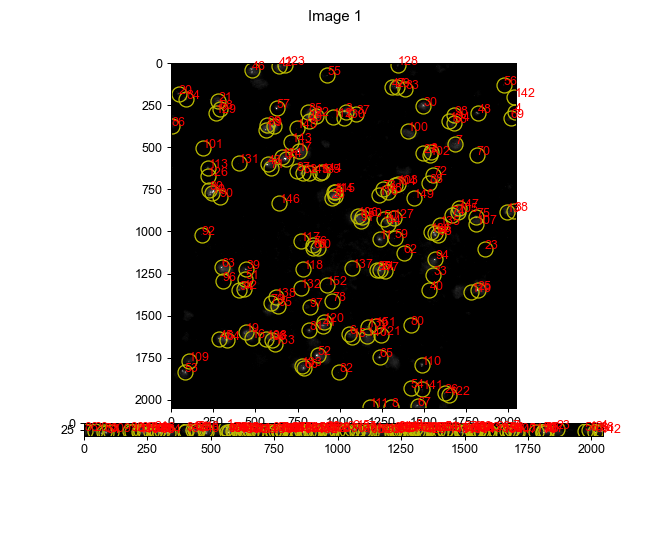

In [8]:
%matplotlib notebook
%matplotlib notebook
## visualize
before_coord_dict = {'coords':[np.flipud(_coord) for _coord in before_chrom_coords],
                     'class_ids':list(before_fov_inds_list),
                    }

visual_tools.imshow_mark_3d_v2(before_chrom_ims, 
                               given_dic=before_coord_dict,    # param to show selection
                               save_file=None,
                               )


In [13]:
# select_hzxys close to the chromosome center
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 3000nm
good_chr_th = 0.8 # 80% of regions should have candidate spots
intensity_th = 200 
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

NameError: name 'dna_cand_hzxys_list' is not defined

### 2. Process image into candidate spots

## select spots based on chromosomes

In [ ]:
fov._load_from_file('unique')

In [ ]:
intensity_th = 200
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes

kept_spots_list = []
for _spots in fov.unique_spots_list:
    kept_spots_list.append(_spots[_spots[:,0] > intensity_th])
# finalize candidate spots
cand_chr_spots_list = [[] for _ct in fov.chrom_coords]
for _spots in kept_spots_list:
    _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
    for _i, _cands in enumerate(_cands_list):
        cand_chr_spots_list[_i].append(_cands)
print(f"kept chromosomes: {len(fov.chrom_coords)}")

In [ ]:
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys

dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids
dna_reg_channels = fov.unique_channels
chrom_coords = fov.chrom_coords


# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 3000nm
good_chr_th = 0.8 # 80% of regions should have candidate spots

sel_dna_cand_hzxys_list = []
sel_chrom_coords = []
chr_cand_pers = []
sel_chr_cand_pers = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _chr_cand_per = 0
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th)])
            _chr_cand_per += 1
    
    _chr_cand_per *= 1/len(_cand_hzxys)
    # append
    if _chr_cand_per >= good_chr_th:
        sel_dna_cand_hzxys_list.append(_sel_cands_list)
        sel_chrom_coords.append(_chrom_coord)
        sel_chr_cand_pers.append(_chr_cand_per)
    
    chr_cand_pers.append(_chr_cand_per)
    
print(f"kept chromosomes: {len(sel_chrom_coords)}")

### EM pick spots

In [ ]:
%matplotlib inline
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import _maximize_score_spot_picking_of_chr, pick_spots_by_intensities,pick_spots_by_scores, generate_reference_from_population, evaluate_differences

niter= 10
num_threads = 24
ref_chr_cts = None
# initialize
init_dna_hzxys = pick_spots_by_intensities(sel_dna_cand_hzxys_list)
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []

for _iter in range(niter):
    print(f"+ iter:{_iter}")
    # E: generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1], dna_reg_ids,
        ref_channels=dna_reg_channels,
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        verbose=True,
    )
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ct_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('center dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_local_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('local dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ints.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('intensity', fontsize=8)
    plt.show()
    
    # M: pick based on scores
    sel_hzxys_list, sel_scores_list, all_scores_list, other_scores_list = \
    pick_spots_by_scores(
        sel_dna_cand_hzxys_list, dna_reg_ids,
        cand_channels=dna_reg_channels, 
        ref_hzxys_list=sel_dna_hzxys_list[-1], ref_ids=dna_reg_ids, ref_channels=dna_reg_channels,
        ref_ct_dists=ref_ct_dists, ref_local_dists=ref_local_dists, ref_ints=ref_ints, 
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        return_other_scores=True,
        verbose=True,
    )
    # check updating rate
    update_rate = evaluate_differences(sel_hzxys_list, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    # append
    sel_dna_hzxys_list.append(sel_hzxys_list)
    sel_dna_scores_list.append(sel_scores_list)
    all_dna_scores_list.append(all_scores_list)
    
    plt.figure(figsize=(4,2), dpi=100)
    plt.hist(np.concatenate([np.concatenate(_scores) 
                       for _scores in other_scores_list]), 
             bins=np.arange(-15,0), alpha=0.5, label='unselected')
    plt.hist(np.ravel([np.array(_sel_scores) 
                       for _sel_scores in sel_dna_scores_list[-1]]), 
             bins=np.arange(-15,0), alpha=0.5, label='selected')
    plt.legend(fontsize=8)
    plt.show()
    
    if update_rate > 0.998:
        break

In [ ]:
dna_reg_ids

In [ ]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = -5
int_th = 200
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    # remove spots by intensity
    _bad_inds = _kept_hzxys[:,0] < int_th
    # remove spots by scores
    _bad_inds += _scores < score_th
    #print(np.mean(_bad_inds))
    _kept_hzxys[_bad_inds] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
#kept_chrom_coords = np.array(sel_chrom_coords)[kept_chr_ids]
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

In [ ]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
print(np.mean(loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_ylim([0,1])
ax.set_xticks(np.arange(0,len(dna_reg_ids),int(len(dna_reg_ids)/5)))
plt.show()

In [ ]:
dna_reg_ids[np.where(loss_rates>0.8)[0]]

In [ ]:
imaging_order = []
for _fd, _infos in fov.color_dic.items():
    for _info in _infos:
        if len(_info) > 0 and _info[0] == 'u':
            if int(_info[1:]) in dna_reg_ids:
                imaging_order.append(list(dna_reg_ids).index(int(_info[1:])))
imaging_order = np.array(imaging_order, dtype=np.int)
#kept_inds = imaging_order # plot imaging ordered regions

#kept_inds = np.where(loss_rates<0.5)[0] # plot good regions only
kept_inds = np.arange(len(fov.unique_ids)) # plot all

%matplotlib inline

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"v-Abl ProB iaa_dox_STI+, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 20)
ax.set_xticks(_ticks)
ax.set_xticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_xlabel(f"5kb region id", fontsize=7, labelpad=2)
ax.set_yticks(_ticks)
ax.set_yticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_ylabel(f"5kb region id", fontsize=7, labelpad=2)


ax.axvline(x=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])
ax.axhline(y=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

## visualize single example

In [ ]:
%matplotlib inline


reload(figure_tools.image)

chrom_id = 3

import matplotlib
import copy

sc_cmap = copy.copy(matplotlib.cm.get_cmap('seismic_r'))
sc_cmap.set_bad(color=[0.5,0.5,0.5,1])

#valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]
valid_inds = np.ones(len(final_dna_hzxys_list[chrom_id]), dtype=np.bool) # all spots

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(
        distmap_list[chrom_id][valid_inds][:,valid_inds], 
        color_limits=[0,600],
        ax=ax,
        cmap=sc_cmap,
        ticks=np.arange(0,150,20), 
        figure_dpi=200)
ax.set_title(f"proB DMSO chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

ax3d = figure_tools.image.chromosome_structure_3d_rendering(
        final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
        marker_edge_line_width=0,
        reference_bar_length=200, image_radius=300, 
        line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

In [ ]:
?figure_tools.image.chromosome_structure_3d_rendering

## visualize all fitted spots

In [ ]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    raw_spots_list = [_spots[_spots[:,0] > 0] for _spots in _grp['raw_spots'][:]]
    spots_list = [_spots[_spots[:,0] > 0] for _spots in _grp['spots'][:]]

In [ ]:
from scipy.spatial.distance import cdist
picked_spot_inds_list = []
for _i, _id in enumerate(dna_reg_ids):
    _cand_hzxys = spots_list[_i][:,1:4] * fov.shared_parameters['distance_zxy']
    _dists = cdist(np.array(final_dna_hzxys_list)[:,_i,1:], _cand_hzxys)#, axis=1
    _matched_spot_inds = []
    for _ds in _dists:
        if np.sum(np.isnan(_ds)) < len(_ds) and np.nanmin(_ds) < 0.01:
            _matched_spot_inds.append(np.argmin(_ds))
        else:
            _matched_spot_inds.append(np.nan)
    # append
    picked_spot_inds_list.append(np.array(_matched_spot_inds))

In [ ]:
#vis_inds = [0,1,2,3,4,5]
vis_inds = np.where(loss_rates > 0.8)[0]
vis_ims, vis_ids, vis_spot_list, vis_raw_spot_list = [], [], [], []

with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    
    for _ind in vis_inds:
        vis_ims.append(_grp['ims'][_ind])
        vis_ids.append(_grp['ids'][_ind])
        _picked_inds = picked_spot_inds_list[_ind]
        _picked_inds = np.array(_picked_inds[np.isnan(_picked_inds)==False], dtype=np.int)
        vis_spot_list.append(raw_spots_list[_ind][_picked_inds])

In [ ]:
dna_reg_ids[59]

In [ ]:
fov.color_dic

In [ ]:
# visualize_all_chromosomes
%matplotlib notebook
%matplotlib notebook

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }
for _i, _spots in enumerate(vis_spot_list):
    coord_dict['coords'] += list(np.flipud(_spot[1:4]) for _spot in _spots)
    coord_dict['class_ids'] += list(_i * np.ones(len(_spots),dtype=np.int))

fig=plt.figure(figsize=(4,6), dpi=150)    
    
visual_tools.imshow_mark_3d_v2(vis_ims, 
                               fig=fig,
                               given_dic=coord_dict,
                               save_file=None,
                               )